## **Laboration 3 Deep Convolutional Generative Adversarial Network (GAN)**


Generativa modeller har fått en hel del uppmärksamhet i bland de som sysslar med Deep Learning.  Ett GAN består av två stycken subnätverk, som i nedan kod kallas för "the generator" respektive "the discriminator". Det förstnämnda "the generator" skapar utifrån vad som nedan refereras till ett "frö" (seed) som indata med strävan att skapa utdata i form av syntetiska falska siffror (bilderna i MNIST) som inte går att skilja på från de äkta siffrorna  i  MNIST datasetet. Det sistnämnda "the discriminator" strävar efter att kunna skilja på de falska och äkta siffrorna.  

För varje träningsiteration så skapar "the generator" mer realistiska falska siffror dvs miminerar skillnaden mellan den äkta siffran och den skapade falska siffran. "The discriminator" däremot försöker maximera sannolikheten att siffran får den rätta etiketten dvs äkta eller falsk på både de äkta exemplen från datasetet såväl som de skapade falska siffrorna. De två mål som dessa nätverk har står i konflikt med varandra och leder vid träning att GAN nätverket konvergerar till en jämvikt där "the generator" producerar realistiska men falska MNIST siffror och "the disciminator" kan som bäst slumpmässigt gissa om siffran är äkta eller falsk. 

Radford, Metz och Chintala (2016, s.3) ger några riktlinjer vid skapandet av ett GAN. Ett av dessa är man skall använda "BatchNormalization" i båda modellerna dvs. "the generator" och "the discriminator, vilket görs för att stabilisera lärandet.  "BatchNormalization" normaliserar indata till varje enhet i modellen genom att ha noll både som medelvärde och varians för enheten, vilket skall hjälpa till att hantera träningsprolem som uppstår pga. av dålig initiering och hjälper flödet hos gradienten i djupare modeller. Detta har visat sig vara kritiskt för att få "the generator" att börja lära sig och förhindra att denna från att kollapsa i avsendet att urvalet kretsar kring en punkt.  I det givna exemplet nedan så är det dock bara "the generator" som använder "BatchNormalization". Jag ville så testa vad som hände om jag tog bort denna möjlighet även för "the generator". Först så körde jag med "BatchNormalization" och sedan ändrade jag manuellt till med (dvs. jag gjorde ingen finurlig kodning för att åstadkomma detta utan satte relevanta rader som kommentarer). Resultatet av att använda "BatchNoramlization" som i det ursprungliga exeplet blev att "the egenerator" efter hand skapade bättre och mer lika siffror som de i datasetet. När jag tog botr "BatchNormalization" så resulterade detta i att "the generator" inte skapade några siffror utan det blev bara svarta rutor. Det är inte omöjligt att anledningen är att  "the generator" överhuvudtaget inte kommer igång att börja lära sig eller kanske mindre sannolikt har kollapsat enligt ovan.

**Referenser**

Radford, Metz & Chintala (2016). Unsupervised Representation Learning with Deep Convolutional Generative Adversial Networks., Conference paper ICLR 2016.



### Importera TensorFlow och andra bibliotek

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
!pip install -q tensorflow-gpu==2.0.0-beta1


     |████████████████████████████████| 348.9MB 57kB/s 
     |████████████████████████████████| 3.1MB 42.8MB/s 
     |████████████████████████████████| 501kB 45.6MB/s 


In [0]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0-beta1'

In [0]:
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Ladda och förberedd datasetet

Datasetet MNIST som vi redan är bekanta med sedan tidigare i kursen används. MNIST datasetet används för att träna "the generator" och "the discriminator". "The generator" kommer skapa handskrivna siffror som liknar data  som finns i MNIST datasetet.  

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Skapa modellerna



### The Generator

"The generator" använder `tf.keras.layers.Conv2DTranspose` lager för att skapa en bild från från ett "frö". Startar med ett "Dense" lager som  tar detta "frö" och sedan uppsamplar detta flera gånger till den önskade bildstorleken 28x28x1. Notera "tf.keras.layers.LeakyReLU" aktiveringen för varje lager förutom utdatalagret som använder "tanh".

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    #model.add(layers.BatchNormalization())  # Första körningen med andra utan "BatchNormalization".
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    #model.add(layers.BatchNormalization()) # Första körningen med andra utan "BatchNormalization".
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    #model.add(layers.BatchNormalization()) # Första körningen med andra utan "BatchNormalization".
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

"The generator" används för att skapa en bild

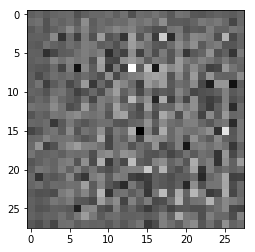

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100]) # Skapar slumpmässigt brus som initialiserar "the generator".
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

"The discriminator" är en CNN baserad bildklassificerare.

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Använd "the discrimator" för att klassificera skapade bilder som äkta eller falska genom att utdata blir positiva värden för äkta bilder och negativa för falska. 

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00341803]], shape=(1, 1), dtype=float32)


## Definiera loss och optimerare för båda modellerna. 


In [0]:
# Denna metod returnerar en hjälp funktion för att beräka "cross entropy loss".

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Denna metod kvantifierar hur väl "the discriminator" kan skilja på äkta och falska bilder. Den jämför "the discriminators" prediktion för
verkliga bilder till en array av ettor (1) och "the discriminators" prediktioner på falska (skapade) bilder till en array nollor (0).
T

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
"The generator's" loss kvantifierar hur väl den lurade "the discriminator". Intutitivt ifall "the generator" presterar väl så kommer "the discriminator" klassficiera den falska bilden som äkta (1). Här jämförs "the discriminators" beslut på den skapade bilderna med en array av ettor (1). 

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

"The discriminator" and "the generator"optimerna är olika eftersom de tränas seperat.  

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Spara checkpunkter 


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definera träningsloopen



In [0]:
EPOCHS = 50
noise_dim = 100  
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Träningsloopen börjar med att "the generator" tar emot ett slumpmässigt "frö" som indata vilket används för att skapa en bild. "The discriminator" används sedan för att klassificiera verkliga bilder från träningsdatasetet och falska bilder som skapats av "the generator". Loss beräknas för varje model och gradienterna används för att updatera "the generator" och "the discriminator".  

In [0]:
# Motera användningen av "tf.function" vilket får funktionen att "kompileras".

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Skapa bilder för GIFen
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Spara modellen efter varje 15 epoch
    
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Skapa efter den slutgiltiga epochen
  
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

 ## Skapa och spara bilder 



In [0]:
def generate_and_save_images(model, epoch, test_input):
  
  # Notera att "training" är satt till "False".
  # Detta göra att alla lager körs i "inference mode (batchnorm).
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Träna modellen

Anropar "train()"" metoden som definerats ovan för att träna "the generator" och  "the discriminator" samtidigt. Det är viktigt att dessa tränar i samma hastighet.  I början av träningen så ser de skapade bilderna ut som slumpmässigt brus. Efter ungefär 50 epochs så liknar de MNIST siffror. 
.

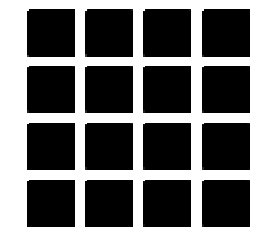

CPU times: user 2min 35s, sys: 42.2 s, total: 3min 17s
Wall time: 9min 26s


In [24]:
%%time
train(train_dataset, EPOCHS)

Återställ till senaste checkpunkten

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Skapa en GIF


In [0]:
# Skapa en bild med epoch numret.

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

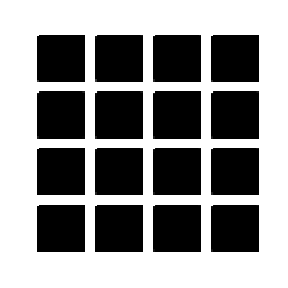

In [27]:
display_image(EPOCHS)

"imageio` används för att skapa en animerad guf med de bilder som sparats under träningen. 

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)